In [81]:
import pandas as pd
import nltk
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import Word2Vec
import numpy as np
from gensim.models import KeyedVectors
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the dataset
amazon_data = pd.read_csv("Reviews.csv")
amazon_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
train_data, test_data = train_test_split(amazon_data, test_size=0.2, random_state=42)

In [4]:
# Download necessary resources from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    
    # Remove stop words and lemmatize
    clean_tokens = []
    for token in tokens:
        if token not in stop_words:
            clean_token = lemmatizer.lemmatize(token)
            clean_tokens.append(clean_token)
    
    # Join tokens back into string
    clean_text = " ".join(clean_tokens)
    
    return clean_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Apply preprocessing function to train and test datasets
train_data["clean_text"] = train_data["Text"].apply(preprocess_text)

In [6]:
test_data["clean_text"] = test_data["Text"].apply(preprocess_text)

# Feature Extraction

#### BOW

In [7]:
# Create CountVectorizer object
bow_vectorizer = CountVectorizer()

In [8]:
# Fit vectorizer on train set
train_bow = bow_vectorizer.fit_transform(train_data['clean_text'])

In [9]:
# Transform test set using fitted vectorizer
test_bow = bow_vectorizer.transform(test_data['clean_text'])

#### n-gram

In [10]:
# Create CountVectorizer object with n-gram range of (1,2)
ngram_vectorizer = CountVectorizer(ngram_range=(1,2))

In [11]:
# Fit and transform train data
train_ngram = ngram_vectorizer.fit_transform(train_data['clean_text'])

In [12]:
# Transform test data
test_ngram = ngram_vectorizer.transform(test_data['clean_text'])

#### TF-IDF

In [13]:
# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer()

In [14]:
# Fit and transform train data
train_tfidf = tfidf_vectorizer.fit_transform(train_data['clean_text'])

In [15]:
# Transform test data
test_tfidf = tfidf_vectorizer.transform(test_data['clean_text'])

#### CBOW

In [16]:
# Train CBOW model
cbow_model = Word2Vec(train_data["clean_text"].apply(lambda x: x.split()), min_count=1, window=5, workers=4, sg=0)

In [17]:
# Convert preprocessed text to CBOW embeddings
train_cbow = np.zeros((len(train_data), 100))
for i, doc in enumerate(train_data["clean_text"]):
    tokens = doc.split()
    embeddings = [cbow_model.wv[token] for token in tokens if token in cbow_model.wv]
    if embeddings:
        train_cbow[i] = np.mean(embeddings, axis=0)

In [18]:
test_cbow = np.zeros((len(test_data), 100))
for i, doc in enumerate(test_data["clean_text"]):
    tokens = doc.split()
    embeddings = [cbow_model.wv[token] for token in tokens if token in cbow_model.wv]
    if embeddings:
        test_cbow[i] = np.mean(embeddings, axis=0)

#### Skip Gram

In [19]:
# Train Skip Gram model on preprocessed text
skipgram_model = Word2Vec(train_data["clean_text"].apply(lambda x: x.split()), min_count=1, window=5, workers=4, sg=1)

In [20]:
# Convert preprocessed text to Skip Gram embeddings
train_skipgram = np.zeros((len(train_data), 100))
for i, doc in enumerate(train_data["clean_text"]):
    tokens = doc.split()
    embeddings = [skipgram_model.wv[token] for token in tokens if token in skipgram_model.wv]
    if embeddings:
        train_skipgram[i] = np.mean(embeddings, axis=0)

In [21]:
test_skipgram = np.zeros((len(test_data), 100))
for i, doc in enumerate(test_data["clean_text"]):
    tokens = doc.split()
    embeddings = [skipgram_model.wv[token] for token in tokens if token in skipgram_model.wv]
    if embeddings:
        test_skipgram[i] = np.mean(embeddings, axis=0)

# Modeling

In [82]:
# Define a parameter grid to search over
param_grid = {'C': [0.1, 1, 10]}

## Logistic Regression

#### Logistic Regression - BOW

In [182]:
lr_bow = LogisticRegression()

In [183]:
grid_search_lr_bow = GridSearchCV(lr_bow, param_grid, cv=5)

In [184]:
# train the model on the training set
grid_search_lr_bow.fit(train_bow, train_data['Score'])

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10]})

In [185]:
# Print the best hyperparameters
print('Best hyperparameters:', grid_search_bow.best_params_)

Best hyperparameters: {'C': 0.1}


#### Logistic Regression - n-gram

In [145]:
lr_ngram = LogisticRegression()

In [146]:
grid_search_lr_ngram = GridSearchCV(lr_ngram, param_grid, cv=5)

In [147]:
# train the model on the training set
grid_search_lr_ngram.fit(train_ngram, train_data['Score'])

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10]})

In [148]:
# Print the best hyperparameters
print('Best hyperparameters:', grid_search_lr_ngram.best_params_)

Best hyperparameters: {'C': 0.1}


#### Logistic Regression - TF-IDF

In [149]:
lr_tfidf = LogisticRegression()

In [150]:
grid_search_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, cv=5)

In [151]:
# train the model on the training set
grid_search_lr_tfidf.fit(train_tfidf, train_data['Score'])

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10]})

In [152]:
# Print the best hyperparameters
print('Best hyperparameters:', grid_search_lr_tfidf.best_params_)

Best hyperparameters: {'C': 10}


#### Logistic Regression - CBOW

In [153]:
# Train Logistic Regression model on BOW features
lr_cbow = LogisticRegression(max_iter=1000)

In [154]:
grid_search_lr_cbow = GridSearchCV(lr_cbow, param_grid, cv=5)

In [155]:
# train the model on the training set
grid_search_lr_cbow.fit(train_cbow, train_data['Score'])

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10]})

In [156]:
# Print the best hyperparameters
print('Best hyperparameters:', grid_search_lr_cbow.best_params_)

Best hyperparameters: {'C': 0.1}


#### Logistic Regression - Skip Gram

In [157]:
lr_skipgram = LogisticRegression(max_iter=1000)

In [158]:
grid_search_lr_skipgram = GridSearchCV(lr_skipgram, param_grid, cv=5)

In [159]:
# train the model on the training set
grid_search_lr_skipgram.fit(train_skipgram, train_data['Score'])

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10]})

In [160]:
# Print the best hyperparameters
print('Best hyperparameters:', grid_search_lr_skipgram.best_params_)

Best hyperparameters: {'C': 0.1}


## SVM

#### SVM - BOW

In [161]:
svm_bow = SVC()

In [162]:
grid_search_svm_bow = GridSearchCV(svm_bow, param_grid, cv=5)

In [163]:
# train the model on the training set
grid_search_svm_bow.fit(train_bow, train_data['Score'])

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.1, 1, 10]})

In [164]:
# Print the best hyperparameters
print('Best hyperparameters:', grid_search_svm_bow.best_params_)

Best hyperparameters: {'C': 0.1}


#### SVM - n-gram

In [165]:
svm_ngram = SVC()

In [166]:
grid_search_svm_ngram = GridSearchCV(svm_ngram, param_grid, cv=5)

In [167]:
# train the model on the training set
grid_search_svm_ngram.fit(train_ngram, train_data['Score'])

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.1, 1, 10]})

In [168]:
# Print the best hyperparameters
print('Best hyperparameters:', grid_search_svm_ngram.best_params_)

Best hyperparameters: {'C': 10}


#### SVM - TF-IDF

In [169]:
svm_tfidf = SVC()

In [170]:
grid_search_svm_tfidf = GridSearchCV(svm_tfidf, param_grid, cv=5)

In [171]:
# train the model on the training set
grid_search_svm_tfidf.fit(train_tfidf, train_data['Score'])

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.1, 1, 10]})

In [172]:
# Print the best hyperparameters
print('Best hyperparameters:', grid_search_svm_tfidf.best_params_)

Best hyperparameters: {'C': 0.1}


#### SVM - CBOW

In [173]:
svm_cbow = SVC()

In [174]:
grid_search_svm_cbow = GridSearchCV(svm_cbow, param_grid, cv=5)

In [175]:
# train the model on the training set
grid_search_svm_cbow.fit(train_cbow, train_data['Score'])

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.1, 1, 10]})

In [176]:
# Print the best hyperparameters
print('Best hyperparameters:', grid_search_svm_cbow.best_params_)

Best hyperparameters: {'C': 0.1}


#### SVM - Skip Gram

In [177]:
svm_skipgram = SVC()

In [178]:
grid_search_svm_skipgram = GridSearchCV(svm_skipgram, param_grid, cv=5)

In [179]:
# train the model on the training set
grid_search_svm_skipgram.fit(train_skipgram, train_data['Score'])

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.1, 1, 10]})

In [180]:
# Print the best hyperparameters
print('Best hyperparameters:', grid_search_svm_skipgram.best_params_)

Best hyperparameters: {'C': 0.1}


## Model Evaluation

### 5.1. Logistic Regression

#### Logistic Regression - BOW

In [186]:
best_lr_bow = grid_search_lr_bow.best_estimator_
pred_lr_bow_train = best_lr_bow.predict(train_bow)

Training accuracy (BOW): 87.38%
Training F1-score (BOW): 86.59%
.............................................


<AxesSubplot: >

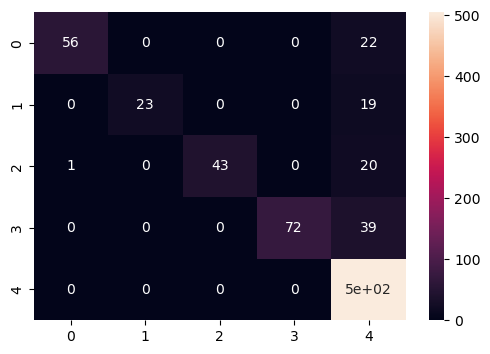

In [187]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_lr_bow_train = accuracy_score(train_data["Score"], pred_lr_bow_train)
f1_lr_bow_train = f1_score(train_data["Score"], pred_lr_bow_train, average='weighted')
cm_lr_bow_train = confusion_matrix(train_data["Score"], pred_lr_bow_train)


print("Training accuracy (BOW): {:0.4g}%".format((acc_lr_bow_train)*100))
print("Training F1-score (BOW): {:0.4g}%".format((f1_lr_bow_train)*100))

print('...'*15)
df_cm_lr_bow_train = pd.DataFrame(cm_lr_bow_train)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_lr_bow_train, annot=True)

#### Logistic Regression - n-gram

In [188]:
# predict the labels for the test set
best_lr_ngram = grid_search_lr_ngram.best_estimator_
pred_lr_ngram_train = best_lr_ngram.predict(train_ngram)

Training accuracy (n-gram): 96.38%
Training F1-score (n-gram): 96.33%
.............................................


<AxesSubplot: >

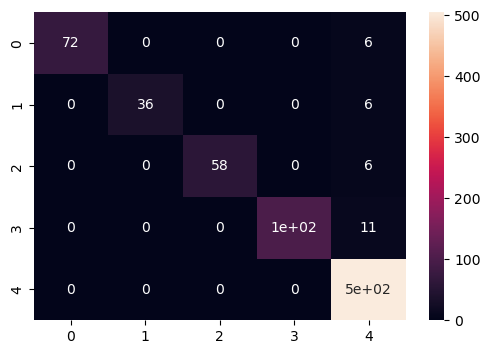

In [189]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_lr_ngram_train = accuracy_score(train_data["Score"], pred_lr_ngram_train)
f1_lr_ngram_train = f1_score(train_data["Score"], pred_lr_ngram_train, average='weighted')
cm_lr_ngram_train = confusion_matrix(train_data["Score"], pred_lr_ngram_train)


print("Training accuracy (n-gram): {:0.4g}%".format((acc_lr_ngram_train)*100))
print("Training F1-score (n-gram): {:0.4g}%".format((f1_lr_ngram_train)*100))

print('...'*15)
df_cm_lr_ngram_train = pd.DataFrame(cm_lr_ngram_train)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_lr_ngram_train, annot=True)

#### Logistic Regression - TF-IDF

In [190]:
# predict the labels for the test set
best_lr_tfidf = grid_search_lr_tfidf.best_estimator_
pred_lr_tfidf_train = best_lr_tfidf.predict(train_tfidf)

Training accuracy (TF-IDF): 100%
Training F1-score (TF-IDF): 100%
.............................................


<AxesSubplot: >

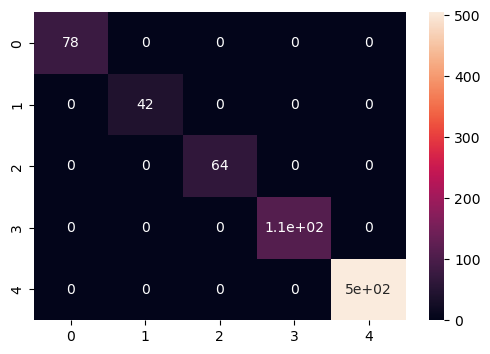

In [191]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_lr_tfidf_train = accuracy_score(train_data["Score"], pred_lr_tfidf_train)
f1_lr_tfidf_train = f1_score(train_data["Score"], pred_lr_tfidf_train, average='weighted')
cm_lr_tfidf_train = confusion_matrix(train_data["Score"], pred_lr_tfidf_train)


print("Training accuracy (TF-IDF): {:0.4g}%" .format((acc_lr_tfidf_train)*100))
print("Training F1-score (TF-IDF): {:0.4g}%".format((f1_lr_tfidf_train)*100))

print('...'*15)
df_cm_lr_tfidf_train = pd.DataFrame(cm_lr_tfidf_train)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_lr_tfidf_train, annot=True)

#### Logistic Regression - CBOW

In [192]:
# Predict on test data and evaluate model
best_lr_cbow = grid_search_lr_cbow.best_estimator_
pred_lr_cbow_train = best_lr_cbow.predict(train_cbow)

Training accuracy (CBOW): 63.12%
Training F1-score (CBOW): 48.86%
.............................................


<AxesSubplot: >

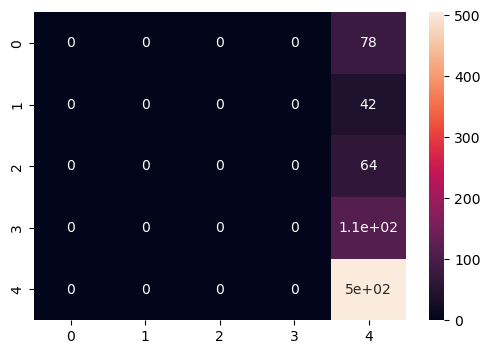

In [193]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_lr_cbow_train = accuracy_score(train_data["Score"], pred_lr_cbow_train)
f1_lr_cbow_train = f1_score(train_data["Score"], pred_lr_cbow_train, average='weighted')
cm_lr_cbow_train = confusion_matrix(train_data["Score"], pred_lr_cbow_train)


print("Training accuracy (CBOW): {:0.4g}%".format((acc_lr_cbow_train)*100))
print("Training F1-score (CBOW): {:0.4g}%".format((f1_lr_cbow_train)*100))

print('...'*15)
df_cm_lr_cbow_train = pd.DataFrame(cm_lr_cbow_train)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_lr_cbow_train, annot=True)

#### Logistic Regression - Skip Gram

In [194]:
best_lr_skipgram = grid_search_lr_skipgram.best_estimator_
pred_lr_skipgram_train = best_lr_skipgram.predict(train_skipgram)

Training accuracy (Skip Gram): 63.12%
Training F1-score (Skip Gram): 48.86%
.............................................


<AxesSubplot: >

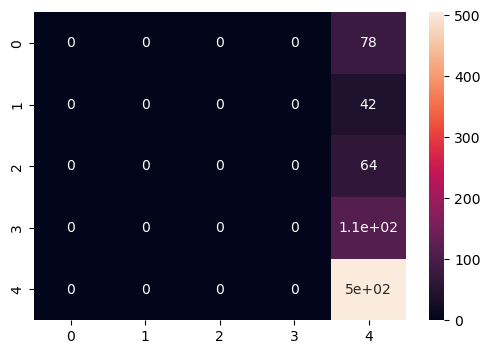

In [195]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_lr_skipgram_train = accuracy_score(train_data["Score"], pred_lr_skipgram_train)
f1_lr_skipgram_train = f1_score(train_data["Score"], pred_lr_skipgram_train, average='weighted')
cm_lr_skipgram_train = confusion_matrix(train_data["Score"], pred_lr_skipgram_train)


print("Training accuracy (Skip Gram): {:0.4g}%".format((acc_lr_skipgram_train)*100))
print("Training F1-score (Skip Gram): {:0.4g}%".format((f1_lr_skipgram_train)*100))

print('...'*15)
df_cm_lr_skipgram_train = pd.DataFrame(cm_lr_skipgram_train)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_lr_skipgram_train, annot=True)

### SVM

#### SVM - BOW

In [196]:
# predict the labels for the test set
best_svm_bow = grid_search_svm_bow.best_estimator_
pred_svm_bow_train = best_svm_bow.predict(train_bow)

Training accuracy (BOW): 63.12%
Training F1-score (BOW): 48.86%
.............................................


<AxesSubplot: >

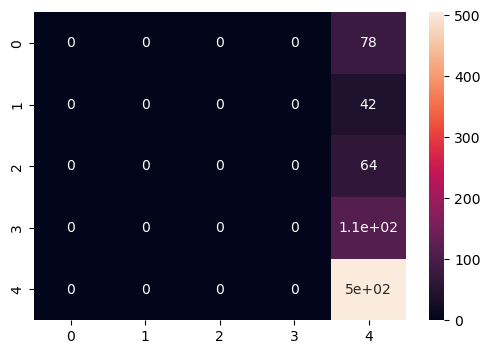

In [197]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_svm_bow_train = accuracy_score(train_data["Score"], pred_svm_bow_train)
f1_svm_bow_train = f1_score(train_data["Score"], pred_svm_bow_train, average='weighted')
cm_svm_bow_train = confusion_matrix(train_data["Score"], pred_svm_bow_train)


print("Training accuracy (BOW): {:0.4g}%".format((acc_svm_bow_train)*100))
print("Training F1-score (BOW): {:0.4g}%".format((f1_svm_bow_train)*100))

print('...'*15)
df_cm_svm_bow_train = pd.DataFrame(cm_svm_bow_train)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_svm_bow_train, annot=True)

#### SVM - n-gram

In [198]:
# predict the labels for the test set
best_svm_ngram = grid_search_svm_ngram.best_estimator_
pred_svm_ngram_train = best_svm_ngram.predict(train_ngram)

Training accuracy (n-gram): 100%
Training F1-score (n-gram): 100%
.............................................


<AxesSubplot: >

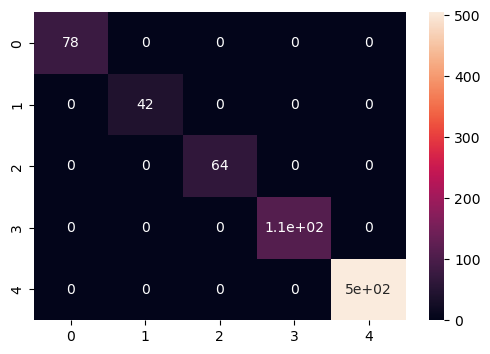

In [199]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_svm_ngram_train = accuracy_score(train_data["Score"], pred_svm_ngram_train)
f1_svm_ngram_train = f1_score(train_data["Score"], pred_svm_ngram_train, average='weighted')
cm_svm_ngram_train = confusion_matrix(train_data["Score"], pred_svm_ngram_train)


print("Training accuracy (n-gram): {:0.4g}%".format((acc_svm_ngram_train)*100))
print("Training F1-score (n-gram): {:0.4g}%".format((f1_svm_ngram_train)*100))

print('...'*15)
df_cm_svm_ngram_train = pd.DataFrame(cm_svm_ngram_train)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_svm_ngram_train, annot=True)

#### SVM - TF-IDF

In [200]:
# predict the labels for the test set
best_svm_tfidf = grid_search_svm_tfidf.best_estimator_
pred_svm_tfidf_train = best_svm_tfidf.predict(train_tfidf)

Training accuracy (TF-IDF): 63.12%
Training F1-score (TF-IDF): 48.86%
.............................................


<AxesSubplot: >

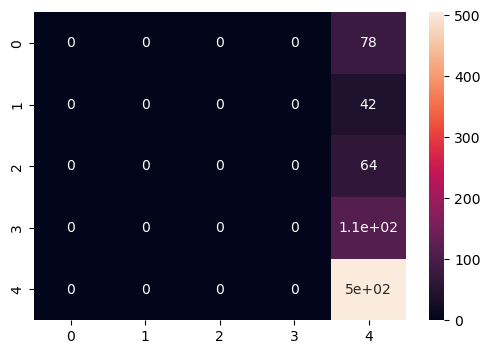

In [201]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_svm_tfidf_train = accuracy_score(train_data["Score"], pred_svm_tfidf_train)
f1_svm_tfidf_train = f1_score(train_data["Score"], pred_svm_tfidf_train, average='weighted')
cm_svm_tfidf_train = confusion_matrix(train_data["Score"], pred_svm_tfidf_train)


print("Training accuracy (TF-IDF): {:0.4g}%".format((acc_svm_tfidf_train)*100))
print("Training F1-score (TF-IDF): {:0.4g}%".format((f1_svm_tfidf_train)*100))

print('...'*15)
df_cm_svm_tfidf_train = pd.DataFrame(cm_svm_tfidf_train)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_svm_tfidf_train, annot=True)

#### SVM - CBOW

In [202]:
# evaluate the model on the test set
best_svm_cbow = grid_search_svm_cbow.best_estimator_
pred_svm_cbow_train = best_svm_cbow.predict(train_cbow)

Training accuracy (CBOW): 63.12%
Training F1-score (CBOW): 48.86%
.............................................


<AxesSubplot: >

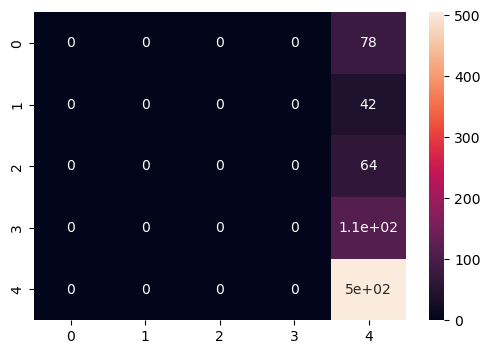

In [203]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_svm_cbow_train = accuracy_score(train_data["Score"], pred_svm_cbow_train)
f1_svm_cbow_train = f1_score(train_data["Score"], pred_svm_cbow_train, average='weighted')
cm_svm_cbow_train = confusion_matrix(train_data["Score"], pred_svm_cbow_train)


print("Training accuracy (CBOW): {:0.4g}%".format((acc_svm_cbow_train)*100))
print("Training F1-score (CBOW): {:0.4g}%".format((f1_svm_cbow_train)*100))

print('...'*15)
df_cm_svm_cbow_train = pd.DataFrame(cm_svm_cbow_train)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_svm_cbow_train, annot=True)

#### SVM - Skip Gram

In [204]:
# evaluate the model on the test set
best_svm_skipgram = grid_search_svm_skipgram.best_estimator_
pred_svm_skipgram_train = best_svm_skipgram.predict(train_skipgram)

Training accuracy (Skip Gram): 63.12%
Training F1-score (Skip Gram): 48.86%
.............................................


<AxesSubplot: >

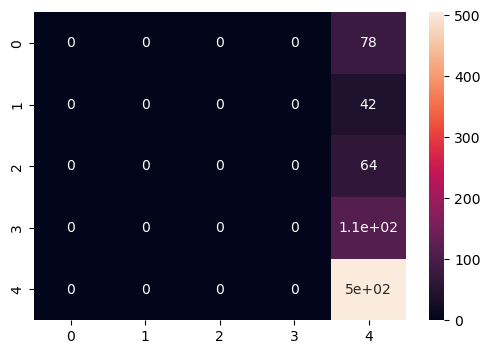

In [205]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_svm_skipgram_train = accuracy_score(train_data["Score"], pred_svm_skipgram_train)
f1_svm_skipgram_train = f1_score(train_data["Score"], pred_svm_skipgram_train, average='weighted')
cm_svm_skipgram_train = confusion_matrix(train_data["Score"], pred_svm_skipgram_train)


print("Training accuracy (Skip Gram): {:0.4g}%".format((acc_svm_skipgram_train)*100))
print("Training F1-score (Skip Gram): {:0.4g}%".format((f1_svm_skipgram_train)*100))

print('...'*15)
df_cm_svm_skipgram_train = pd.DataFrame(cm_svm_skipgram_train)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_svm_skipgram_train, annot=True)

## Evaluate the model on the test set

### Logistic Regression

#### Logistic Regression - BOW

In [207]:
# predict the labels for the test set
best_lr_bow = grid_search_lr_bow.best_estimator_
pred_lr_bow_test = best_lr_bow.predict(test_bow)

Training accuracy (BOW): 71.5%
Training F1-score (BOW): 62.72%
.............................................


<AxesSubplot: >

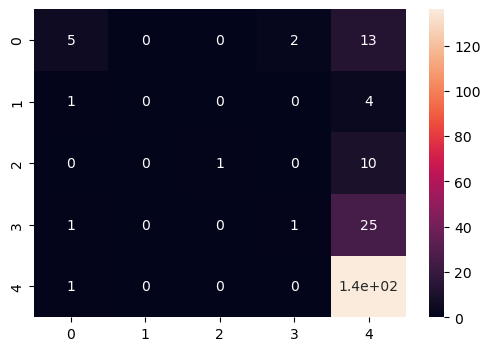

In [208]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_lr_bow_test = accuracy_score(test_data["Score"], pred_lr_bow_test)
f1_lr_bow_test = f1_score(test_data["Score"], pred_lr_bow_test, average='weighted')
cm_lr_bow_test = confusion_matrix(test_data["Score"], pred_lr_bow_test)


print("Training accuracy (BOW): {:0.4g}%".format((acc_lr_bow_test)*100))
print("Training F1-score (BOW): {:0.4g}%".format((f1_lr_bow_test)*100))

print('...'*15)
df_cm_lr_bow_test = pd.DataFrame(cm_lr_bow_test)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_lr_bow_test, annot=True)

#### Logistic Regression - n-gram

In [209]:
# predict the labels for the test set
best_lr_ngram = grid_search_lr_ngram.best_estimator_
pred_lr_ngram_test = best_lr_ngram.predict(test_ngram)

Training accuracy (n-gram): 69%
Training F1-score (n-gram): 58%
.............................................


<AxesSubplot: >

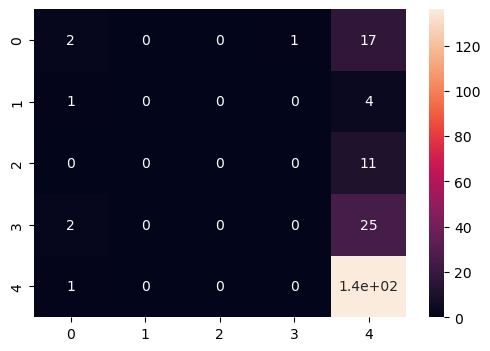

In [210]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_lr_ngram_test = accuracy_score(test_data["Score"], pred_lr_ngram_test)
f1_lr_ngram_test = f1_score(test_data["Score"], pred_lr_ngram_test, average='weighted')
cm_lr_ngram_test = confusion_matrix(test_data["Score"], pred_lr_ngram_test)


print("Training accuracy (n-gram): {:0.4g}%".format((acc_lr_ngram_test)*100))
print("Training F1-score (n-gram): {:0.4g}%".format((f1_lr_ngram_test)*100))

print('...'*15)
df_cm_lr_ngram_test = pd.DataFrame(cm_lr_ngram_test)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_lr_ngram_test, annot=True)

#### Logistic Regression - TF-IDF

In [211]:
# predict the labels for the test set
best_lr_tfidf = grid_search_lr_tfidf.best_estimator_
pred_lr_tfidf_test = best_lr_tfidf.predict(test_tfidf)

Training accuracy (TF-IDF): 71.5%
Training F1-score (TF-IDF): 64.05%
.............................................


<AxesSubplot: >

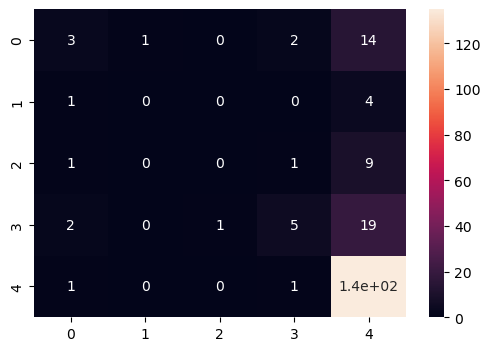

In [212]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_lr_tfidf_test = accuracy_score(test_data["Score"], pred_lr_tfidf_test)
f1_lr_tfidf_test = f1_score(test_data["Score"], pred_lr_tfidf_test, average='weighted')
cm_lr_tfidf_test = confusion_matrix(test_data["Score"], pred_lr_tfidf_test)


print("Training accuracy (TF-IDF): {:0.4g}%".format((acc_lr_tfidf_test)*100))
print("Training F1-score (TF-IDF): {:0.4g}%".format((f1_lr_tfidf_test)*100))

print('...'*15)
df_cm_lr_tfidf_test = pd.DataFrame(cm_lr_tfidf_test)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_lr_tfidf_test, annot=True)

#### Logistic Regression - CBOW

In [213]:
# Predict on test data and evaluate model
best_lr_cbow = grid_search_lr_cbow.best_estimator_
pred_lr_cbow_test = best_lr_cbow.predict(test_cbow)

Training accuracy (CBOW): 68.5%
Training F1-score (CBOW): 55.69%
.............................................


<AxesSubplot: >

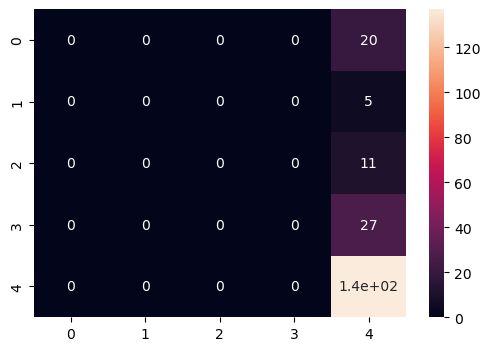

In [214]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_lr_cbow_test = accuracy_score(test_data["Score"], pred_lr_cbow_test)
f1_lr_cbow_test = f1_score(test_data["Score"], pred_lr_cbow_test, average='weighted')
cm_lr_cbow_test = confusion_matrix(test_data["Score"], pred_lr_cbow_test)


print("Training accuracy (CBOW): {:0.4g}%".format((acc_lr_cbow_test)*100))
print("Training F1-score (CBOW): {:0.4g}%".format((f1_lr_cbow_test)*100))

print('...'*15)
df_cm_lr_cbow_test = pd.DataFrame(cm_lr_cbow_test)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_lr_cbow_test, annot=True)

#### Logistic Regression - Skip Gram

In [215]:
best_lr_skipgram = grid_search_lr_skipgram.best_estimator_
pred_lr_skipgram_test = best_lr_skipgram.predict(test_skipgram)

Training accuracy (Skip Gram): 68.5%
Training F1-score (Skip Gram): 55.69%
.............................................


<AxesSubplot: >

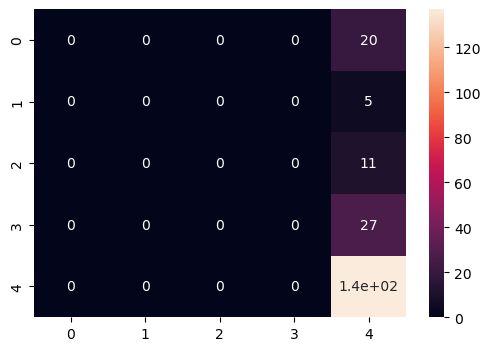

In [216]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_lr_skipgram_test = accuracy_score(test_data["Score"], pred_lr_skipgram_test)
f1_lr_skipgram_test = f1_score(test_data["Score"], pred_lr_skipgram_test, average='weighted')
cm_lr_skipgram_test = confusion_matrix(test_data["Score"], pred_lr_skipgram_test)


print("Training accuracy (Skip Gram): {:0.4g}%".format((acc_lr_skipgram_test)*100))
print("Training F1-score (Skip Gram): {:0.4g}%".format((f1_lr_skipgram_test)*100))

print('...'*15)
df_cm_lr_skipgram_test = pd.DataFrame(cm_lr_skipgram_test)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_lr_skipgram_test, annot=True)

### SVM

#### SVM - BOW

In [217]:
# predict the labels for the test set
best_svm_bow = grid_search_svm_bow.best_estimator_
pred_svm_bow_test = best_svm_bow.predict(test_bow)

Training accuracy (BOW): 68.5%
Training F1-score (BOW): 55.69%
.............................................


<AxesSubplot: >

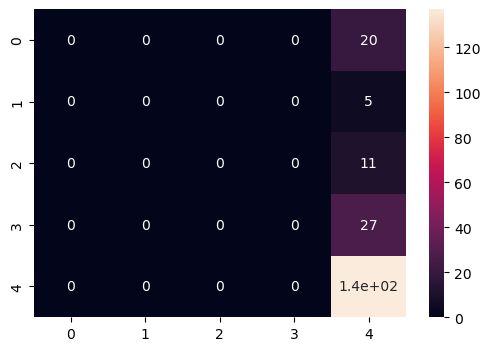

In [218]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_svm_bow_test = accuracy_score(test_data["Score"], pred_svm_bow_test)
f1_svm_bow_test = f1_score(test_data["Score"], pred_svm_bow_test, average='weighted')
cm_svm_bow_test = confusion_matrix(test_data["Score"], pred_svm_bow_test)


print("Training accuracy (BOW): {:0.4g}%".format((acc_svm_bow_test)*100))
print("Training F1-score (BOW): {:0.4g}%".format((f1_svm_bow_test)*100))

print('...'*15)
df_cm_svm_bow_test = pd.DataFrame(cm_svm_bow_test)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_svm_bow_test, annot=True)

#### SVM - n-gram

In [219]:
# predict the labels for the test set
best_svm_ngram = grid_search_svm_ngram.best_estimator_
pred_svm_ngram_test = best_svm_ngram.predict(test_ngram)

Training accuracy (n-gram): 68.5%
Training F1-score (n-gram): 56.55%
.............................................


<AxesSubplot: >

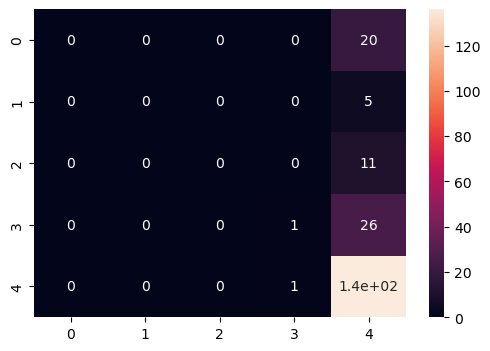

In [220]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_svm_ngram_test = accuracy_score(test_data["Score"], pred_svm_ngram_test)
f1_svm_ngram_test = f1_score(test_data["Score"], pred_svm_ngram_test, average='weighted')
cm_svm_ngram_test = confusion_matrix(test_data["Score"], pred_svm_ngram_test)


print("Training accuracy (n-gram): {:0.4g}%".format((acc_svm_ngram_test)*100))
print("Training F1-score (n-gram): {:0.4g}%".format((f1_svm_ngram_test)*100))

print('...'*15)
df_cm_svm_ngram_test = pd.DataFrame(cm_svm_ngram_test)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_svm_ngram_test, annot=True)

#### SVM - TF-IDF

In [221]:
# predict the labels for the test set
best_svm_tfidf = grid_search_svm_tfidf.best_estimator_
pred_svm_tfidf_test = best_svm_tfidf.predict(test_tfidf)

Training accuracy (TF-IDF): 68.5%
Training F1-score (TF-IDF): 55.69%
.............................................


<AxesSubplot: >

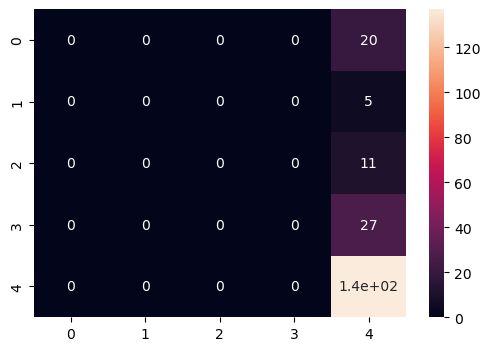

In [222]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_svm_tfidf_test = accuracy_score(test_data["Score"], pred_svm_tfidf_test)
f1_svm_tfidf_test = f1_score(test_data["Score"], pred_svm_tfidf_test, average='weighted')
cm_svm_tfidf_test = confusion_matrix(test_data["Score"], pred_svm_tfidf_test)


print("Training accuracy (TF-IDF): {:0.4g}%".format((acc_svm_tfidf_test)*100))
print("Training F1-score (TF-IDF): {:0.4g}%".format((f1_svm_tfidf_test)*100))

print('...'*15)
df_cm_svm_tfidf_test = pd.DataFrame(cm_svm_tfidf_test)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_svm_tfidf_test, annot=True)

#### SVM - CBOW

In [223]:
# evaluate the model on the test set
best_svm_cbow = grid_search_svm_cbow.best_estimator_
pred_svm_cbow_test = best_svm_cbow.predict(test_cbow)

Training accuracy (CBOW): 68.5%
Training F1-score (CBOW): 55.69%
.............................................


<AxesSubplot: >

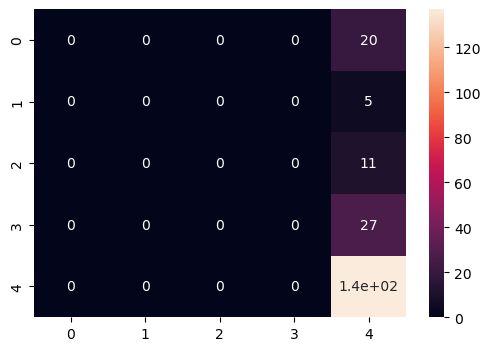

In [224]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_svm_cbow_test = accuracy_score(test_data["Score"], pred_svm_cbow_test)
f1_svm_cbow_test = f1_score(test_data["Score"], pred_svm_cbow_test, average='weighted')
cm_svm_cbow_test = confusion_matrix(test_data["Score"], pred_svm_cbow_test)


print("Training accuracy (CBOW): {:0.4g}%".format((acc_svm_cbow_test)*100))
print("Training F1-score (CBOW): {:0.4g}%".format((f1_svm_cbow_test)*100))

print('...'*15)
df_cm_svm_cbow_test = pd.DataFrame(cm_svm_cbow_test)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_svm_cbow_test, annot=True)

#### SVM - Skip Gram

In [225]:
# evaluate the model on the test set
best_svm_skipgram = grid_search_svm_skipgram.best_estimator_
pred_svm_skipgram_test = best_svm_skipgram.predict(test_skipgram)

Training accuracy (Skip Gram): 68.5%
Training F1-score (Skip Gram): 55.69%
.............................................


<AxesSubplot: >

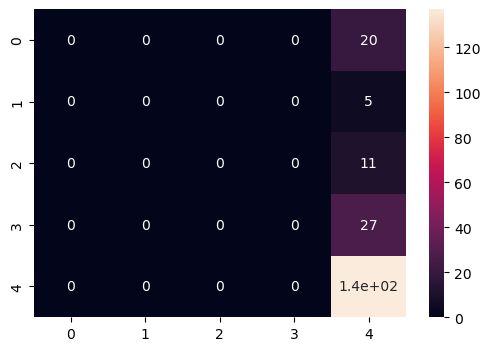

In [226]:
# Calculate accuracy, F1-score, and Confusion Matix on training set
acc_svm_skipgram_test = accuracy_score(test_data["Score"], pred_svm_skipgram_test)
f1_svm_skipgram_test = f1_score(test_data["Score"], pred_svm_skipgram_test, average='weighted')
cm_svm_skipgram_test = confusion_matrix(test_data["Score"], pred_svm_skipgram_test)


print("Training accuracy (Skip Gram): {:0.4g}%".format((acc_svm_skipgram_test)*100))
print("Training F1-score (Skip Gram): {:0.4g}%".format((f1_svm_skipgram_test)*100))

print('...'*15)
df_cm_svm_skipgram_test = pd.DataFrame(cm_svm_skipgram_test)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm_svm_skipgram_test, annot=True)

## Compare the performance on train and test set

In [227]:
Accuracies = {'LR Train': [
                '{0:.4g}%'.format(acc_lr_bow_train*100),
                '{0:.4g}%'.format(acc_lr_ngram_train*100),
                '{0:.4g}%'.format(acc_lr_tfidf_train*100),
                '{0:.4g}%'.format(acc_lr_cbow_train*100),
                '{0:.4g}%'.format(acc_lr_skipgram_train*100)
                ],
             'LR Test': [
                '{0:.4g}%'.format(acc_lr_bow_test*100),
                '{0:.4g}%'.format(acc_lr_ngram_test*100),
                '{0:.4g}%'.format(acc_lr_tfidf_test*100),
                '{0:.4g}%'.format(acc_lr_cbow_test*100),
                '{0:.4g}%'.format(acc_lr_skipgram_test*100)
                ],
             'SVM Train': [
                '{0:.4g}%'.format(acc_svm_bow_train*100),
                '{0:.4g}%'.format(acc_svm_ngram_train*100),
                '{0:.4g}%'.format(acc_svm_tfidf_train*100),
                '{0:.4g}%'.format(acc_svm_cbow_train*100),
                '{0:.4g}%'.format(acc_svm_skipgram_train*100)
                ],
             'SVM Test': [
                '{0:.4g}%'.format(acc_svm_bow_test*100),
                '{0:.4g}%'.format(acc_svm_ngram_test*100),
                '{0:.4g}%'.format(acc_svm_tfidf_test*100),
                '{0:.4g}%'.format(acc_svm_cbow_test*100),
                '{0:.4g}%'.format(acc_svm_skipgram_test*100)
                ]}

summary = pd.DataFrame(Accuracies, index=['BOW', 'n-gram', 'TF-IDF', 'CBOW', 'Skip Gram'])
summary

,LR Train,LR Test,SVM Train,SVM Test
BOW,87.38%,71.5%,63.12%,68.5%
n-gram,96.38%,69%,100%,68.5%
TF-IDF,100%,71.5%,63.12%,68.5%
CBOW,63.12%,68.5%,63.12%,68.5%
Skip Gram,63.12%,68.5%,63.12%,68.5%
